In [1]:
from db_utils import RDSDatabaseConnector, load_data_from_csv
import pandas as pd
from pandas.tseries.offsets import DateOffset
from DataFormat import DataFormat
from DataFrameInfo import DataFrameInfo
from DataTransform import DataFrameTransform
from Plotter import Plotter, plot_percentage_bar_chart
import statsmodels.formula.api as sms


56.224
54.946


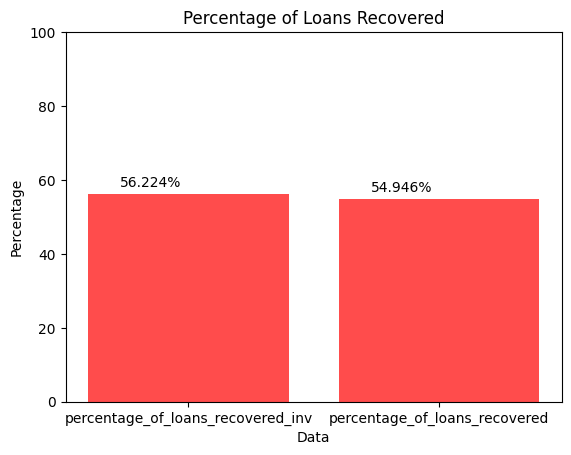

In [2]:
#Load Data
#We need the data before the transformations were applied
df = load_data_from_csv('C:\\Users\\Gurpr\\OneDrive\\Documents\\AI Core\\Exploratory Data Analysis - Customer Loans in Finance\\Data\\Transformed_and_Formatted_loan_data.csv')

#Create a new columns for term length and total expected revenue for analysis 
df['term_numeric'] = df['term'].str.extract('(\d+)').astype(int)
df['total_expected_revenue'] = df['instalment']*df['term_numeric']
df['payments_made'] = df['total_payment'] / df['instalment']
df['months_left'] = df['term_numeric'] - df['payments_made']
#To calculate the current loan recovery status, we can use the total payments and funded amount columns, since if they are equal then 
#the loan has been repaid. 

df['loan_recovery_status_ratio_inv'] = (
    df['total_payment'] / df['funded_amount_inv'])

df['loan_recovery_status_ratio'] = (
    df['total_payment'] / df['funded_amount'])

#Creates a Boolean column to show if the loan has been repaid (True) or not (False)
df['loan_recovered_inv'] = df['loan_recovery_status_ratio_inv'].ge(1)
df['loan_recovered'] = df['loan_recovery_status_ratio'].ge(1)


loan_true_values_inv = (df['loan_recovered_inv']== True).sum()
loan_true_values = (df['loan_recovered']== True).sum()

percentage_of_loans_recovered_inv = round(loan_true_values_inv/ len(df['loan_recovered_inv']) * 100, 3)
percentage_of_loans_recovered = round(loan_true_values/ len(df['loan_recovered']) * 100, 3)

print(percentage_of_loans_recovered_inv)
print(percentage_of_loans_recovered)
#Plot Bar chart 

y = [percentage_of_loans_recovered_inv, percentage_of_loans_recovered]
x = ['percentage_of_loans_recovered_inv', 'percentage_of_loans_recovered']
plot_percentage_bar_chart(x,y, 'Percentage of Loans Recovered')

The respective loan recovery rates are shown in the bar chart. 


Calculating loan recovery in 6 months

We will use the monthly instalments column and multiply iy by 6 (months) and add it to the total payments column to 
calculate how much the customer would have paid nack in 6 months time, then compare with the funded amount to see if the loan has been repaid or not.

In [3]:

copy_df = df[~df['loan_recovered']].copy()
copy_df['total_payment_in_6_months'] = copy_df['total_payment'] + (6*copy_df['instalment'])

copy_df['6months_loan_recovery_status_ratio'] = (
      copy_df['total_payment_in_6_months']/ copy_df['funded_amount'])

#Creates a Boolean column to show if the loan has been repaid (True) or not (False)
copy_df['6months_loan_recovered'] = copy_df['6months_loan_recovery_status_ratio'].ge(1)

six_months_loan_true_values = (copy_df['6months_loan_recovered']== True).sum()
six_months_percentage_of_loans_recovered = round(six_months_loan_true_values/ len(copy_df['6months_loan_recovered']) * 100, 3)


print(six_months_percentage_of_loans_recovered)
percentage_recovered_in_6months = round(six_months_loan_true_values/len(df)*100,3)
print(percentage_recovered_in_6months)

35.996
16.217


Calculating loans recovered at the end of each month 

692
8009


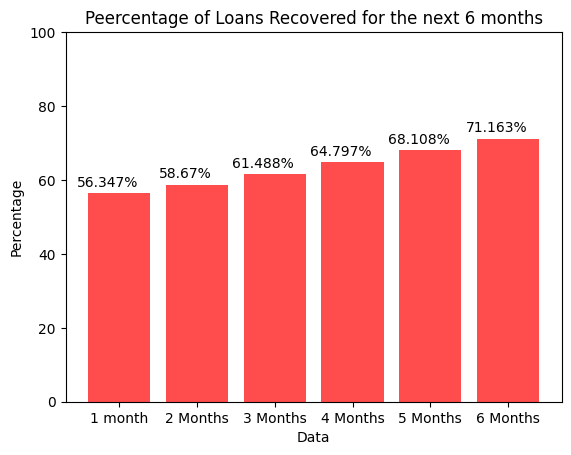

In [4]:
six_month_df = df[~df['loan_recovered']].copy()

six_month_df['one_month'] = six_month_df['total_payment'] + (six_month_df['instalment'])
six_month_df['two_months'] = six_month_df['total_payment'] + (2*six_month_df['instalment'])
six_month_df['three_months'] = six_month_df['total_payment'] + (3*six_month_df['instalment'])
six_month_df['four_months'] = six_month_df['total_payment'] + (4*six_month_df['instalment'])
six_month_df['five_months'] = six_month_df['total_payment'] + (5*six_month_df['instalment'])
six_month_df['six_months'] = six_month_df['total_payment'] + (6*six_month_df['instalment'])


one_month_count = len(six_month_df[six_month_df['one_month'] > six_month_df['funded_amount']])
two_month_count = len(six_month_df[six_month_df['two_months'] > six_month_df['funded_amount']])
three_month_count = len(six_month_df[six_month_df['three_months'] > six_month_df['funded_amount']])
four_month_count = len(six_month_df[six_month_df['four_months'] > six_month_df['funded_amount']])
five_month_count = len(six_month_df[six_month_df['five_months'] > six_month_df['funded_amount']])
six_month_count = len(six_month_df[six_month_df['six_months'] > six_month_df['funded_amount']])


one_month_percent = round(((one_month_count + loan_true_values)/ len(df))*100,3)
two_month_percent = round(((two_month_count + loan_true_values)/ len(df))*100,3)
three_month_percent = round(((three_month_count + loan_true_values)/ len(df))*100,3)
four_month_percent = round(((four_month_count + loan_true_values)/ len(df))*100,3)
five_month_percent = round(((five_month_count + loan_true_values)/ len(df))*100,3)
six_month_percent = round(((six_month_count + loan_true_values)/ len(df))*100,3)

print(one_month_count)
print(six_month_count)
y = [one_month_percent,two_month_percent,three_month_percent,four_month_percent,five_month_percent,six_month_percent]
x = ['1 month', '2 Months', '3 Months', '4 Months', '5 Months', '6 Months']
plot_percentage_bar_chart(x,y, 'Peercentage of Loans Recovered for the next 6 months')

Charged off

In [5]:

charged_off_df = df[df['loan_status'] == 'Charged Off'].copy()

#Percentage charged off
percentage_charged_off = round((len(charged_off_df) / len(df)) * 100, 3)
print(percentage_charged_off)

#Total paid out
paid_total = round(sum(charged_off_df['funded_amount']), 2)
print(paid_total)

#Projected Loss
profit_loss = round(sum(charged_off_df['total_expected_revenue']-charged_off_df['funded_amount']),2)
print(profit_loss) 

10.052
66884375.0
26374929.04


Possible Loss

In [10]:
#Creating a df with Late repayments 
total_late = df['loan_status'].str.contains('Late')
late_df = df.loc[total_late].copy()

#Late/total percentage
percentage_behind = round((len(late_df)/len(df))*100, 3)
print(percentage_behind)


#Amount left to  pay

late_df['total_amount_left'] = late_df['instalment'] * late_df['months_left']
projected_loss = round(sum(late_df['total_amount_left']),2)
print(projected_loss)

#Percentage if loan changed to charge off
new_total = round(((len(late_df) + len(charged_off_df))/len(df))*100,3)
print(new_total)

1.239
6894964.16
11.291
